# Steps going to be followed

* Import the os, numpy, pandas, matplotlib, seaborn, tensorflow and sklearn libraries
* Load the data from the csv file
* Data path connection
* Data resizing
* Build CNN model

[Get the dataset here](https://www.kaggle.com/datasets/arpitjain007/game-of-deep-learning-ship-datasets)

# Import the libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger, CallbackList
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


### Connect the paths and read the data

In [4]:
path = os.getcwd() + "\\train"
train = pd.read_csv(path + "\\train.csv")
train.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [5]:
train.shape

(6252, 2)

In [6]:
train_categories = {1 : 'Cargo',
2 : 'Military',
3 : 'Carrier',
4 : 'Cruise',
5 : 'Tankers'}

### Visualize the data balance

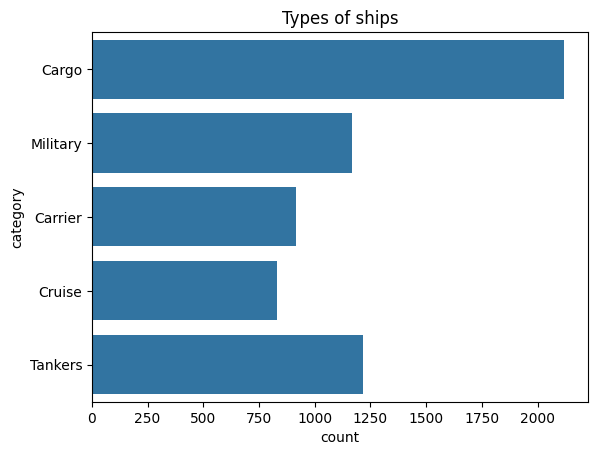

In [7]:
sns.countplot(data=train["category"].map(train_categories))
plt.title("Types of ships")
plt.show()

#### Data resizing

In [ ]:
target_size = (128, 128)
resized_images = []
paths = []
for image in train["image"]:
    img_path = path + f"\\images\\{image}"
    img = tf.keras.utils.load_img(img_path, target_size=target_size)
    img = tf.image.convert_image_dtype(img, tf.float16)
    img = tf.keras.utils.img_to_array(img)
    resized_images.append(img)
    paths.append(img_path)

In [ ]:
resized_images = np.asarray(resized_images)

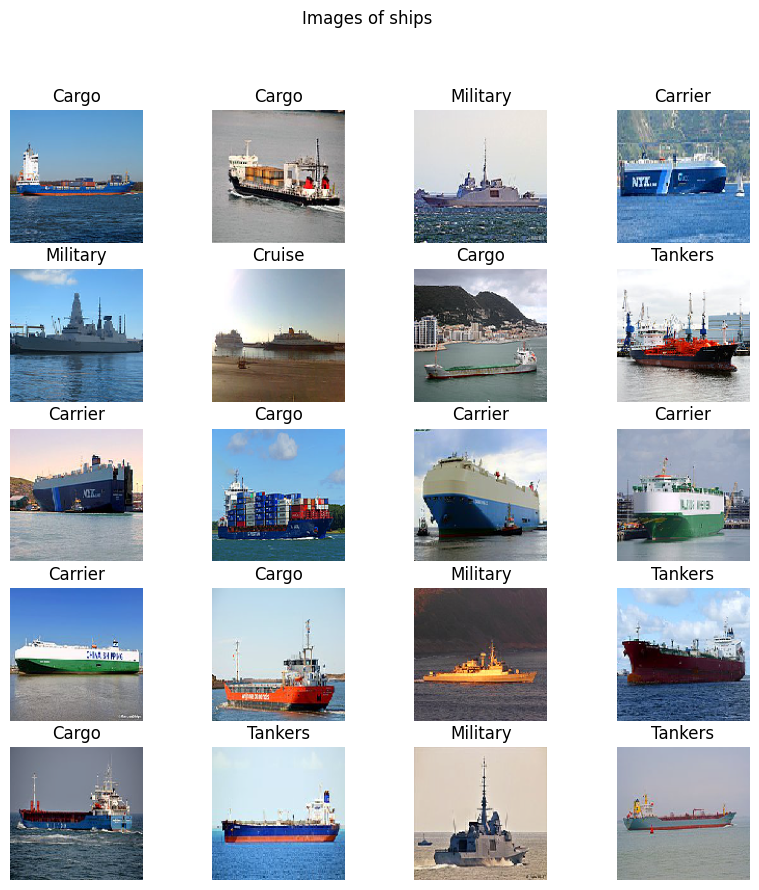

In [ ]:
row = 5
col = 4
plt.figure(figsize=(10, 10))
plt.suptitle("Images of ships")
for i, image in enumerate(resized_images[:row*col], 1):
    plt.subplot(row, col, i)
    plt.imshow(image)
    plt.title(train["category"].map(train_categories)[i-1])
    plt.axis('off')
    plt.grid(False)
plt.show()

#### Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
])

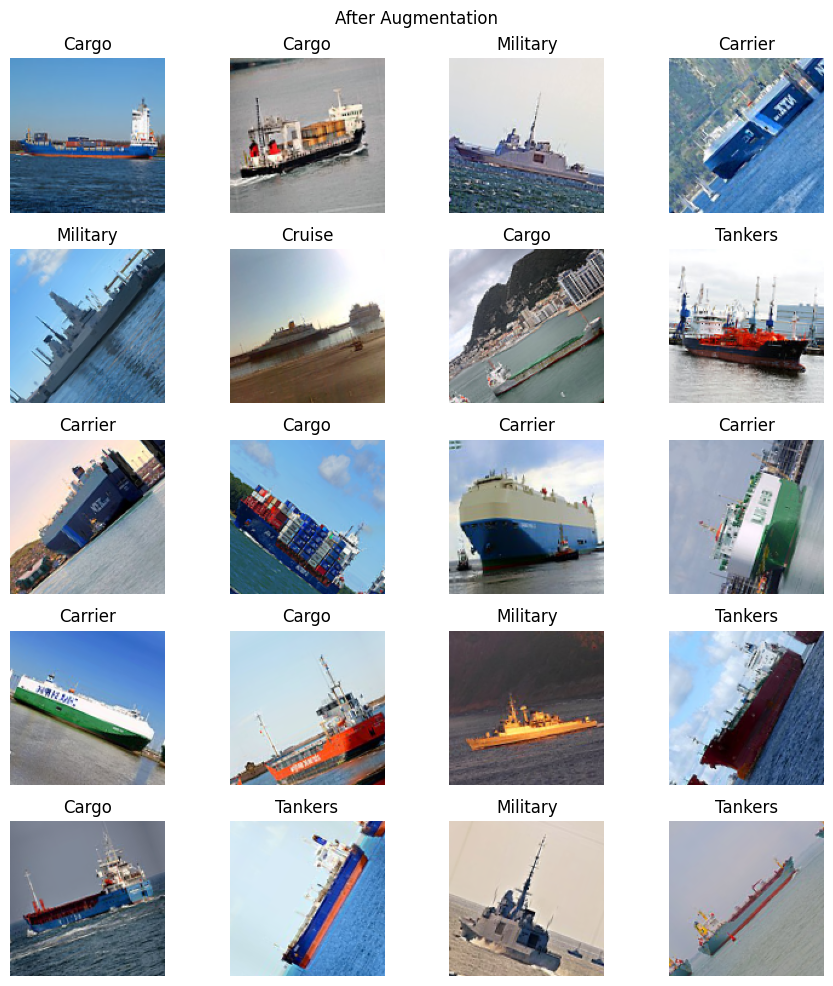

In [ ]:
plt.figure(figsize=(10, 10))
plt.suptitle("After Augmentation")
augmented_image = data_augmentation(resized_images[:20])
for i, image in enumerate(resized_images[:row*col], 1):
    plt.subplot(row, col, i)
    plt.imshow(augmented_image[i-1])
    plt.title(train["category"].map(train_categories)[i-1])
    plt.axis('off')
    plt.grid(False)
    plt.tight_layout(pad=1)
plt.show()

In [ ]:
values = train["category"] - 1
train_categories = {0 : 'Cargo',
1 : 'Military',
2 : 'Carrier',
3 : 'Cruise',
4 : 'Tankers'}

In [ ]:
model = Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    Conv2D(32, (2, 2), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(64, (2, 2), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation="sigmoid"),
    Dense(5, activation="softmax")
])

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 127, 127, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,872,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,881,957 (30.07 MB)

 Trainable params: 7,881,957 (30.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((resized_images, values)).shuffle(1000).batch(batch_size=32).prefetch(tf.data.AUTOTUNE)

In [ ]:
def divide(dataset):
    train_val = 0.8
    test_val = 0.1
    train_size = int(train_val * len(dataset))
    test_size = int(test_val * len(dataset))
    train_dataset = dataset.take(train_size)
    test_dataset = dataset.skip(train_size).take(test_size)
    val_dataset = dataset.skip(train_size + test_size)
    return train_dataset,  test_dataset, val_dataset

In [ ]:
data_train, data_test, data_val = divide(dataset)

In [ ]:
history = model.fit(data_train, epochs=10, validation_data=data_val)

Epoch 1/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 33s 161ms/step - accuracy: 0.3303 - loss: 1.6652 - val_accuracy: 0.4622 - val_loss: 1.2308
Epoch 2/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.5192 - loss: 1.1745 - val_accuracy: 0.5724 - val_loss: 1.0549
Epoch 3/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - accuracy: 0.5572 - loss: 1.0543 - val_accuracy: 0.5707 - val_loss: 1.0092
Epoch 4/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 23s 147ms/step - accuracy: 0.5944 - loss: 1.0009 - val_accuracy: 0.5938 - val_loss: 0.9595
Epoch 5/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 139ms/step - accuracy: 0.6286 - loss: 0.9402 - val_accuracy: 0.6086 - val_loss: 0.9601
Epoch 6/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.6391 - loss: 0.8909 - val_accuracy: 0.6645 - val_loss: 0.7799
Epoch 7/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - accuracy: 0.6615 - loss: 0.8487 - val_accuracy: 0.6447 - val_loss: 0.8710
Epoch 8/10
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 137ms/step - accuracy: 0.6744 - loss: 0

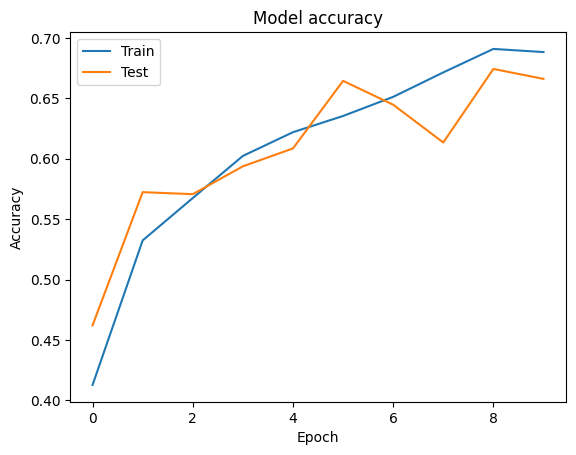

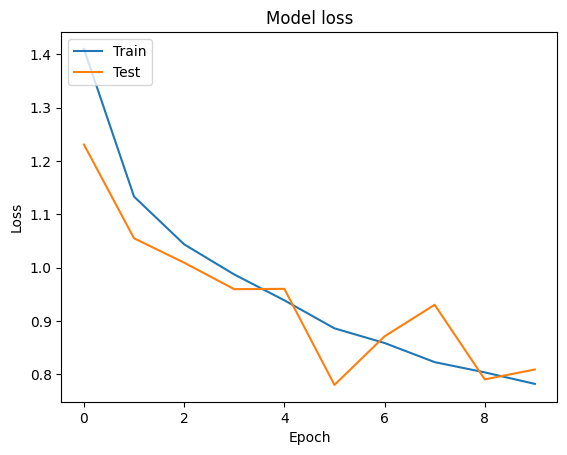

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


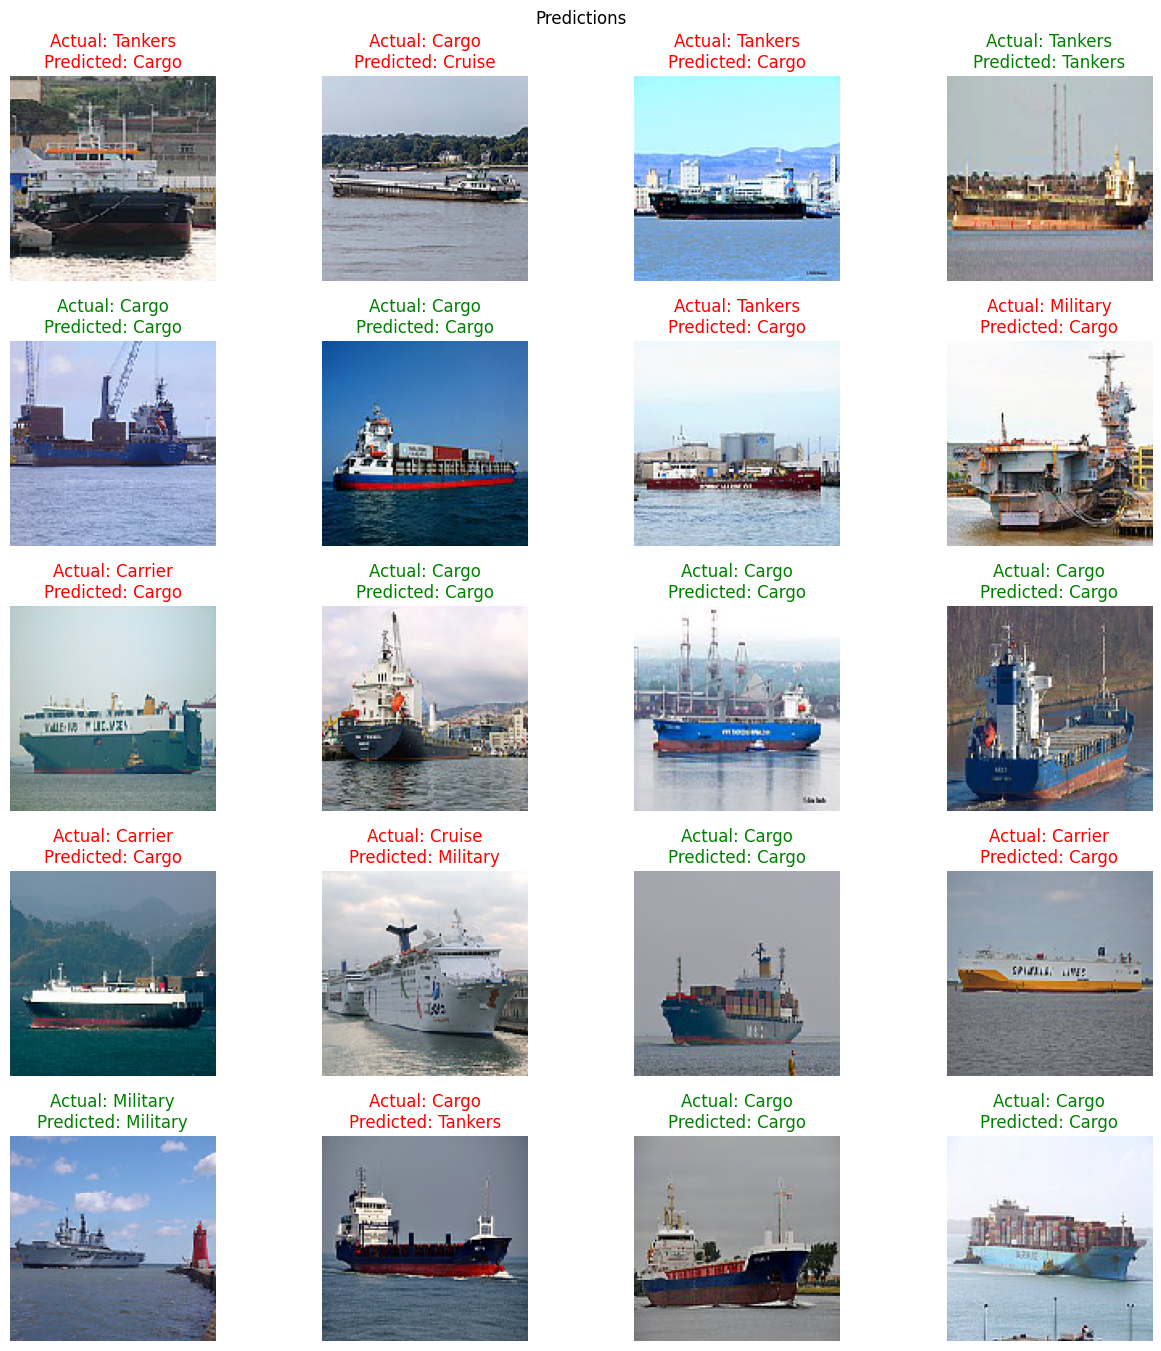

In [ ]:
plt.figure(figsize=(14, 14))
plt.suptitle("Predictions")

for i in data_test:
    image = i[0]
    label = i[1]

for i in range(1, 21):
    plt.subplot(row, col, i)
    plt.imshow(image[i-1])
    prediction = np.argmax(model.predict(tf.expand_dims(image[i-1], 0)))
    prediction = train_categories[prediction]
    actual = train_categories[label[i-1].numpy()]
    if prediction == actual:
        color = "green"
    else:
        color = "red"
    plt.title(f"Actual: {actual}\nPredicted: {prediction}", color=color)
    plt.tight_layout(pad=1.2)
    
    plt.grid(False)
    plt.axis("Off")
plt.show()

In [ ]:
model.save("ship_model.keras")